# Introduction

This presents a Breast Cancer Diagnostics project that is built by using Python’s Scikit-Learn librar using Logistic Regression, Random Forest, and Support Vector Machine to predict which cells are malignant. We also measure the accuracy of models that are built by using Machine Learning, and we assess directions for further development. 

The data was downloaded from Wisconsins's UCI Machine Learning repository. Each row represents samples from Clinical cases, each column contains features of cells.

Source: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

All the data is already scaled from 1-10. This is how observations are scored, it's not a result of data transformation. 

## Pre-processing

In [667]:
#import standard packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#import graphing packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#import modeling packages
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#import feature and hyperparameter tuning packages
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

#import stats packages
from scipy import stats
from scipy.stats import uniform
from sklearn import metrics

#import scoring packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Read csv, create column names and assign to df
df = pd.read_csv('bc.csv', names = ['id', 'clump_thickness', 'uniform_cellsize','uniform_cellshape','marginal_adhesion'
                                    ,'single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli',
                                    'mitoses','class'])
#Drop id (useless column)
df.drop('id', axis=1, inplace = True)
df.head()

,clump_thickness,uniform_cellsize,uniform_cellshape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [668]:
#get shape of data
df.shape

(699, 10)

The data contains 699 observations and 10 features

In [669]:
#get types of data
df.dtypes

clump_thickness                 int64
uniform_cellsize                int64
uniform_cellshape               int64
marginal_adhesion               int64
single_epithelial_cell_size     int64
bare_nuclei                    object
bland_chromatin                 int64
normal_nucleoli                 int64
mitoses                         int64
class                           int64
dtype: object

In [670]:
#Check for other missing data
df.isnull().sum()

clump_thickness                0
uniform_cellsize               0
uniform_cellshape              0
marginal_adhesion              0
single_epithelial_cell_size    0
bare_nuclei                    0
bland_chromatin                0
normal_nucleoli                0
mitoses                        0
class                          0
dtype: int64

In [671]:
#find the unique values of the bn object data
df['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'], dtype=object)

In [672]:
# find number of missing values('?')
(df['bare_nuclei']=='?').sum()

16

The data is fairly clean, we just have a few instances(16/700) of missing data ('?') which we'll remove. All of our data is in type int64. 

In [673]:
#Drop rows with '?'
df = df.replace('?', np.nan).dropna()

#check to make sure '?' have been removed
(df['bare_nuclei']=='?').sum()


0

In [674]:
#re-assign 2 to 0 and 4 to 1
df['class'] = df['class'].replace(2,0)
df['class'] = df['class'].replace(4,1)

## Data Exploration

Now,that we have a clean dataset, we'll start exploring the distributions of the features and outcomes.

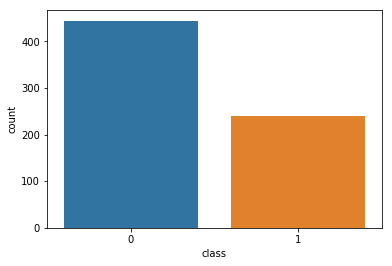

0    444
1    239
Name: class, dtype: int64
% Malignant: 34.99


In [675]:
#graph number of outcomes
sns.countplot('class', data = df)
plt.show()

#print counts of data by outcome(class) 0 is malignant 1 is benign
print(df['class'].value_counts())

#Print % of outcomes thabt are malignant
print("% Malignant: {:.2f}".format((np.sum(df['class'] == 1)/len(df['class']))*100))


About %35 of our outcomes are Malignant. The class imbalance doesn't seem like it will be a problem, so I'll skip any upsampling/downsampling for now and implement it later if I can't get a good model.

In [676]:
#return mean of other features grouped by outcome
df.groupby('class').mean()

,clump_thickness,uniform_cellsize,uniform_cellshape,marginal_adhesion,single_epithelial_cell_size,bland_chromatin,normal_nucleoli,mitoses
class,,,,,,,,
0,2.963964,1.306306,1.414414,1.346847,2.108108,2.083333,1.261261,1.065315
1,7.188285,6.577406,6.560669,5.585774,5.326360,5.974895,5.857741,2.602510


There is a distinct differece between malignant and benign observations in the direction of larger cellshape/sizes, coarser chromatin, and more nucleoli are are strong indicator of tumors being malignant. The difference in mitosis between outcomes has the least contrast. 

In [677]:
#inpsect the bn column with object type
df.groupby('bare_nuclei').mean()

,clump_thickness,uniform_cellsize,uniform_cellshape,marginal_adhesion,single_epithelial_cell_size,bland_chromatin,normal_nucleoli,mitoses,class
bare_nuclei,,,,,,,,,
1,3.072139,1.422886,1.537313,1.420398,2.203980,2.136816,1.358209,1.104478,0.037313
10,7.143939,6.492424,6.598485,6.272727,5.280303,6.227273,5.537879,2.515152,0.977273
2,4.766667,3.300000,2.966667,2.433333,3.166667,3.866667,3.166667,2.066667,0.300000
3,4.678571,3.750000,3.571429,3.321429,3.535714,3.642857,3.392857,1.892857,0.500000
4,6.210526,5.631579,4.842105,2.842105,4.210526,4.210526,5.263158,2.210526,0.684211
5,6.133333,5.100000,5.100000,4.166667,4.200000,4.700000,4.966667,1.800000,0.666667
6,7.750000,6.000000,6.750000,2.250000,5.500000,3.250000,6.500000,4.000000,1.000000
7,7.125000,4.000000,5.000000,4.125000,4.500000,5.625000,6.625000,2.250000,0.875000
8,6.523810,6.952381,7.095238,4.714286,5.857143,6.000000,5.142857,1.476190,0.904762


Looking at the bare_nuclei object,we can see there is a weaker but still prevelent association between higher scores and malignant diagnoses. 

Next we'll examine the distributions and skewness of the data.

clump_thickness 1.09319768285e-13  not normal
uniform_cellsize 5.16939373303e-25  not normal
uniform_cellshape 4.56386742977e-23  not normal
marginal_adhesion 1.09131646507e-35  not normal
single_epithelial_cell_size 4.10003154282e-46  not normal
bland_chromatin 1.58309640398e-21  not normal
normal_nucleoli 2.24258690377e-31  not normal
mitoses 1.26040671956e-112  not normal


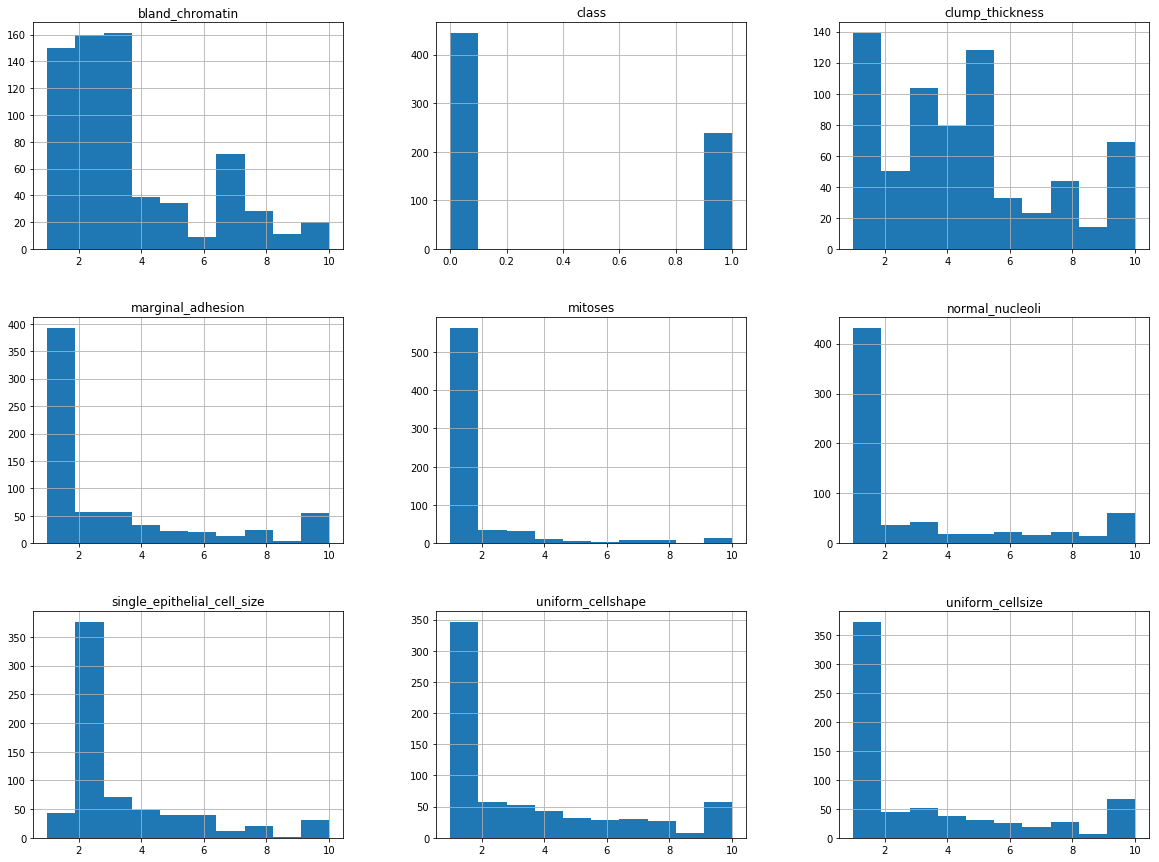

In [678]:


for col in df.columns.drop(['class', 'bare_nuclei']): #initialize loop dropping outcome and object types cols
    _,pval = stats.normaltest(df[col]) 
    if pval > .1:
        print(col, pval)
    else:
        print(col, pval, " not normal")

#assing parameters to histogram
num_bins = 10
df.hist(bins=num_bins, figsize=(20,15))

#plot graphs
plt.show()

None of the data is gaussian and most have a pronounced right skew. I can use a normalcy test to confirm and I'll also plot the data on a violinplot to demonstrate the variance and medians of the data.

clump_thickness 1.09319768285e-13  not normal
uniform_cellsize 5.16939373303e-25  not normal
uniform_cellshape 4.56386742977e-23  not normal
marginal_adhesion 1.09131646507e-35  not normal
single_epithelial_cell_size 4.10003154282e-46  not normal
bland_chromatin 1.58309640398e-21  not normal
normal_nucleoli 2.24258690377e-31  not normal
mitoses 1.26040671956e-112  not normal


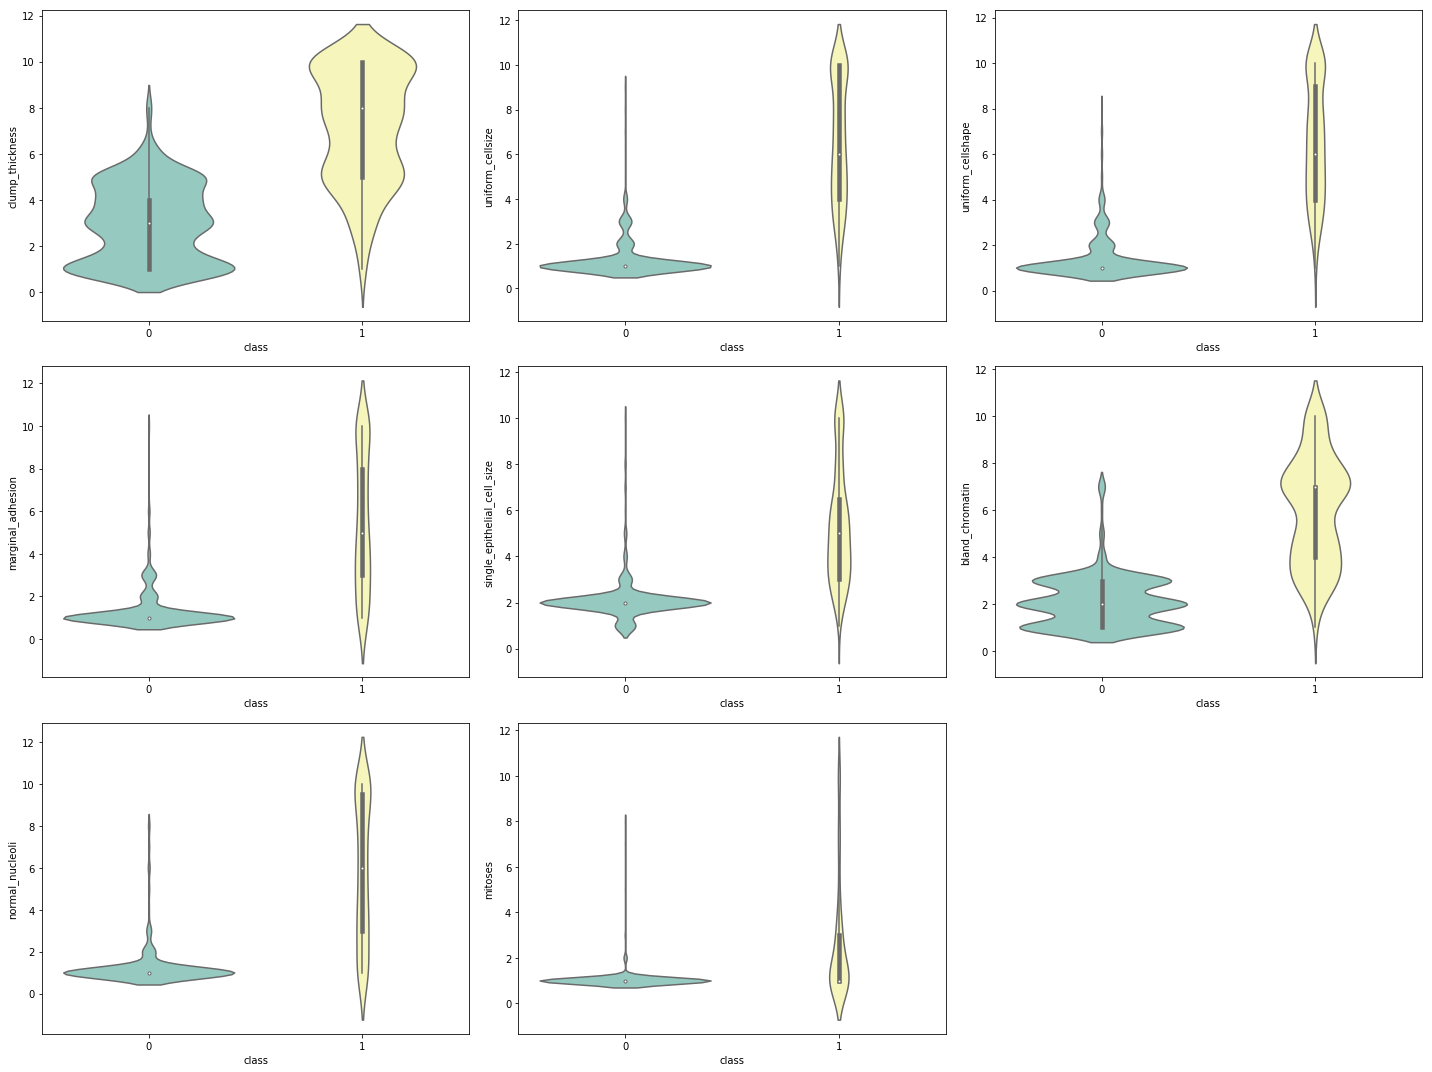

In [679]:
plt.figure(figsize=(20,15))
i = 1
for col in df.columns.drop(['class', 'bare_nuclei']):
    plt.subplot(3,3,i)
    sns.violinplot(x="class", y=col, data=df, palette="Set3")
    i+= 1
    
    _,pval = stats.normaltest(df[col])
    if pval > .05:
        print(col, pval)
    else:
        print(col, pval, " not normal")
plt.tight_layout()
plt.show()

The medians for all featueres, except mitosis, are higher for malignant cells than benign ones. Clump Thickness and Bland Chromatin have the most irregulary shaped data compared to the other features. It's important to note that the malignant cells have a greater variance than the benign cells; The min and max values, across all features, are associated with malignant cells. 

Our data isn't normally distrbuted, so we'll use a Mann Whitney U test to the null hypothesis: the distributions of both populations are equal. Also, our dataset is large enough that we can also run a t-test. These run quickly, so we'll do both.

In [680]:
#run mannwhitneyu
b = df[df['class'] == 0]
m = df[df['class'] == 1]

for col in b.columns.drop(['class', 'bare_nuclei']):
 
     _,val = stats.mannwhitneyu(b[col], m[col])
     if val < .05:
        print('MW : ',col, pval, "Rejct Null")
     else:
        print('MW : ',col, pval)
        
     _,pval = stats.ttest_ind(b[col], m[col])
     if pval < .05:
        print('pval : ',col, val,"Reject Null")
     else:
        print('pval : ',col, val)
     


MW :  clump_thickness 1.26040671956e-112 Rejct Null
pval :  clump_thickness 1.7753362123e-71 Reject Null
MW :  uniform_cellsize 7.29250383846e-108 Rejct Null
pval :  uniform_cellsize 4.40455598323e-112 Reject Null
MW :  uniform_cellshape 8.92222628244e-168 Rejct Null
pval :  uniform_cellshape 9.01200233712e-108 Reject Null
MW :  marginal_adhesion 1.36942492293e-168 Rejct Null
pval :  marginal_adhesion 5.19510052252e-83 Reject Null
MW :  single_epithelial_cell_size 2.97977760901e-104 Rejct Null
pval :  single_epithelial_cell_size 2.14375012842e-91 Reject Null
MW :  bland_chromatin 4.73353974095e-98 Rejct Null
pval :  bland_chromatin 1.62659725895e-84 Reject Null
MW :  normal_nucleoli 1.26771179168e-128 Rejct Null
pval :  normal_nucleoli 2.07946256123e-85 Reject Null
MW :  mitoses 1.4656453681e-109 Rejct Null
pval :  mitoses 1.87158455196e-43 Reject Null


All have p and u values that are essentialy 0. We can assume the distributions are not equal. We'll move on to feature correlations


In [681]:
#return correlations
df.corr()

,clump_thickness,uniform_cellsize,uniform_cellshape,marginal_adhesion,single_epithelial_cell_size,bland_chromatin,normal_nucleoli,mitoses,class
clump_thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.553742,0.534066,0.350957,0.714790
uniform_cellsize,0.642481,1.000000,0.907228,0.706977,0.753544,0.755559,0.719346,0.460755,0.820801
uniform_cellshape,0.653470,0.907228,1.000000,0.685948,0.722462,0.735344,0.717963,0.441258,0.821891
marginal_adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.668567,0.603121,0.418898,0.706294
single_epithelial_cell_size,0.523596,0.753544,0.722462,0.594548,1.000000,0.618128,0.628926,0.480583,0.690958
bland_chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,1.000000,0.665602,0.346011,0.758228
normal_nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.665602,1.000000,0.433757,0.718677
mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.346011,0.433757,1.000000,0.423448
class,0.714790,0.820801,0.821891,0.706294,0.690958,0.758228,0.718677,0.423448,1.000000


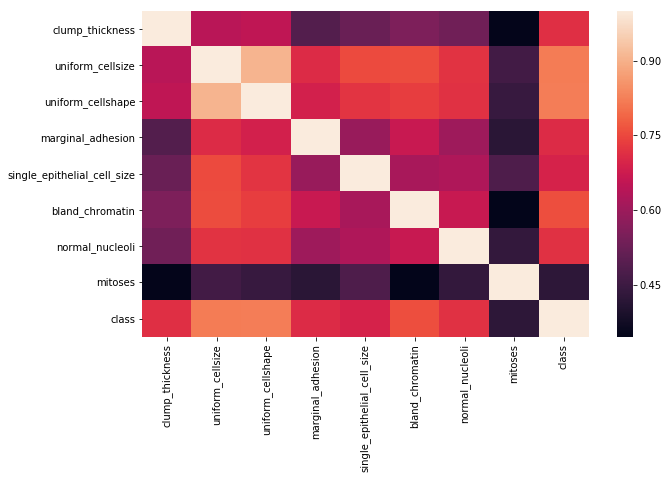

In [682]:
#create correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr())
plt.show()

Most of our features have similiar correlations to our outcomes. Cell Size and cell shape are virtually the same. We'll combind them into the same feature or drop one of them depending on how they perform with a simple model.



In [683]:
df_combined = df
df_drop_shape = df.drop('uniform_cellshape' ,axis = 1)
df_drop_size =df.drop('uniform_cellsize',axis =1)
df_combined['cell_size_shape'] = (df['uniform_cellshape']+df['uniform_cellsize'])/2
df_combined = df_combined.drop(['uniform_cellshape','uniform_cellsize'], axis =1)

# Check how well the composite correlates with each of the individual variables.
plotdf = df.loc[:, ['uniform_cellsize', 'uniform_cellshape', 'cell_size_shape','class']]

corrmat2 = plotdf.corr()

print(corrmat2)

                   uniform_cellsize  uniform_cellshape  cell_size_shape  \
uniform_cellsize           1.000000           0.907228         0.977129   
uniform_cellshape          0.907228           1.000000         0.975927   
cell_size_shape            0.977129           0.975927         1.000000   
class                      0.820801           0.821891         0.841075   

                      class  
uniform_cellsize   0.820801  
uniform_cellshape  0.821891  
cell_size_shape    0.841075  
class              1.000000  


The new feature correlates well with their parent features.

## Data Modeling

In [684]:
#Assign outcome(class) to Y and seperate from dataset
y=df['class']
X=df.loc[:, ~df.columns.isin(['class'])]

#Assign outcome(class) to Y and seperate from dataset for cell shape/size feature datest
y_com=df_combined['class']
X_com=df_combined.loc[:, ~df_combined.columns.isin(['class'])]

#Assign outcome(class) to Y and seperate from dataset for data with the size feature
y_size=df_drop_shape['class']
X_size=df_drop_shape.loc[:, ~df_drop_shape.columns.isin(['class'])]

#Assign outcome(class) to Y and seperate from dataset for data with the shape feature
y_shape=df_drop_size['class']
X_shape=df_drop_size.loc[:, ~df_drop_size.columns.isin(['class'])]


#train test split data for original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.30,
                                                  random_state=123)
#train test split data for shape/size dataset
X_train_com, X_test_com, y_train_com, y_test_com = train_test_split(X_com, y_com,
                                                  test_size = 0.30,
                                                  random_state=123)
#train test split data for the size only feature dataset
X_train_size, X_test_size, y_train_size, y_test_size = train_test_split(X_size, y_size,
                                                  test_size = 0.30,
                                                  random_state=123)
#train test split data for the shape only feature dataset
X_train_shape, X_test_shape, y_train_shape, y_test_shape = train_test_split(X_shape, y_shape,
                                                  test_size = 0.30,
                                                  random_state=123)

    


In [685]:
#instantiate lr model
lr= LogisticRegression()

#fit and train original df
lr.fit(X_train, y_train)
y_pred= lr.predict(X_test)
scores_lr = cross_val_score(lr, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr.mean(), 
                                                                      scores_lr.std()*2))

#fit and train combined df
lr.fit(X_train_com, y_train_com)
y_pred_com= lr.predict(X_test_com)
scores_lr1 = cross_val_score(lr, X_train_com, y_train_com, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr1.mean(), 
                                                                      scores_lr1.std()*2))

#fit and train dropped shape df
lr.fit(X_train_size, y_train_size)
y_pred_size= lr.predict(X_test_size)
scores_lr2 = cross_val_score(lr, X_train_size, y_train_size, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr2.mean(), 
                                                                      scores_lr2.std()*2))

#fit and train dropped size df
lr.fit(X_train_shape, y_train_shape)
y_pred_shape= lr.predict(X_test_shape)
scores_lr3 = cross_val_score(lr, X_train_size, y_train_size, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr3.mean(), 
                                                                      scores_lr3.std()*2))


Cross Validation Accuracy Scores: 0.964(+/- 0.05)
Cross Validation Accuracy Scores: 0.964(+/- 0.05)
Cross Validation Accuracy Scores: 0.964(+/- 0.05)
Cross Validation Accuracy Scores: 0.964(+/- 0.05)


My model improves ever so slightly by dropping one of the size of shape features, or by including the combined variable. I'll use the model with the combined variable going forward.(df_combined)

#### Further Feature reduction and Logistic Regression

In [686]:
#drop outcome from shape/size df
df_combined.drop('class', axis =1, inplace = True)

In [687]:
#instantiate and fit Feature Reduction model
rfe = RFE(model, 6)
rfe = rfe.fit(X_com, y_com)
print(rfe.support_)
print(rfe.ranking_)

#assign rankings to column_num variable and print
column_num = rfe.ranking_
#assing column name to col_names and print 
col_names =df_combined.columns.tolist()
print("Column names:")
print(col_names)


[ True False False  True  True  True  True  True]
[1 2 3 1 1 1 1 1]
Column names:
['clump_thickness', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'cell_size_shape']


In [688]:
#Turn the ranking above into a list and cut out features that aren't scored '1'

#assign cols to an empty list
cols = []
#create a for loop that enumerates indexes and values
for idx, val in enumerate(column_num):
    if val == 1:
        cols.append(idx)
        
        
#use cols list to create new array of the features I want to keep
X_slim=df_combined.iloc[:, cols]
X_slim.head()

,clump_thickness,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,cell_size_shape
0,5,1,3,1,1,1.0
1,5,10,3,2,1,4.0
2,3,2,3,1,1,1.0
3,6,4,3,7,1,8.0
4,4,1,3,1,1,1.0


Cross Validation Accuracy Scores: 0.960(+/- 0.05)
             precision    recall  f1-score   support

          0       0.97      0.98      0.97       312
          1       0.96      0.94      0.95       166

avg / total       0.96      0.96      0.96       478



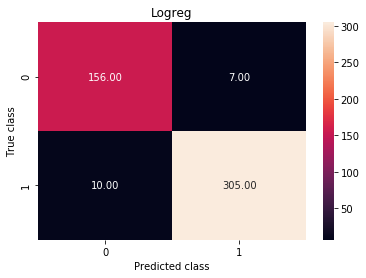

In [689]:

#set train size to 70%/30% train/test because the dataset is small
X_train, X_test, y_train, y_test = train_test_split(X_slim, y_com,
                                                    test_size =0.30,
                                                    random_state = 123)
lr.fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr.mean(), 
                                                                      scores_lr.std()*2))


y_pred = lr.predict(X_train)
lr_cm = metrics.confusion_matrix(y_pred, y_train, [1,0])
sns.heatmap(lr_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logreg')
plt.savefig('Logreg')
print(classification_report(y_train, lr.predict(X_train)))

This is looking pretty good. We can eliminate the marginal_adhesion and single_epithelial_cell_size features and still maintain the same accuracy across folds in our model.  We cut our original features from 9 down to 6 and we have a model that seems to be fairly well balanced.

Next, we'll do some hyperparamter tuning with Randomized Search

In [690]:
# Create logistic regression
logistic = LogisticRegression()

# Create regularization penalty
#penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

#create solver hyperparameter
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create hyperparameter options
hyperparameters = dict(C=C, solver = solver)

# Create randomized search 5-fold cross validation and 25 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=123, n_iter=100, cv=5, verbose=1, n_jobs=-1)

# Fit randomized search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters 
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best penalty: l2
Best C: 0.907405814257
Best solver: lbfgs


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


Cross Validation Accuracy Scores: 0.962(+/- 0.05)
             precision    recall  f1-score   support

          0       0.97      0.98      0.97       312
          1       0.96      0.94      0.95       166

avg / total       0.96      0.96      0.96       478



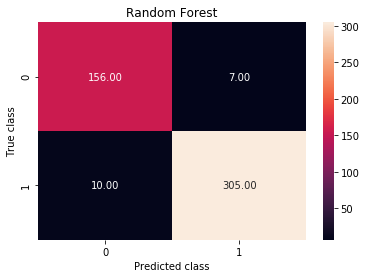

In [691]:
lr1 = LogisticRegression(penalty = 'l2',
                           C = 0.938051500729,
                           solver = 'saga')
lr1.fit(X_train, y_train)
scores_lr1 = cross_val_score(lr1, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr1.mean(), 
                                                                      scores_lr1.std()*2))

y_pred = lr1.predict(X_train)
lr1_cm = metrics.confusion_matrix(y_pred, y_train, [1,0])
sns.heatmap(lr1_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('Random Forest')
print(classification_report(y_train, lr1.predict(X_train)))

Hyperparameter tuning didn't affect the models accuracy. I'll stick with the original model. We'll try a Random Forest Classifier next.

#### Random Forest

Cross Validation Accuracy Scores: 0.958(+/- 0.06)
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       312
          1       0.99      0.99      0.99       166

avg / total       0.99      0.99      0.99       478



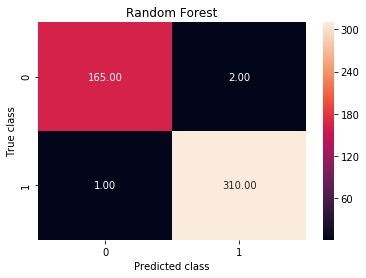

In [692]:

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
scores_rf = cross_val_score(rf, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rf.mean(), 
                                                                      scores_rf.std()*2))

y_pred = rf.predict(X_train)
rf_cm = metrics.confusion_matrix(y_pred, y_train, [1,0])
sns.heatmap(rf_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('Random Forest')
print(classification_report(y_train, rf.predict(X_train)))

My Random Forest model performs quite well out of the box, but ideally we'd have no type 2 errors. Let's do a little tuning with Randomized Search. The dataset is rather small, so this should run quickly.

In [693]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [694]:

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Create hyperparamater values
n_estimators = np.arange(1,100,5)
max_depth = np.arange(1, 30, 5)
min_samples_leaf = np.arange(1, 20, 1)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators,
                       max_depth = max_depth,
                       min_samples_leaf = min_samples_leaf)

# Create randomized search 3-fold cross validation and 100 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(rf, hyperparameters, random_state=1, n_iter=100, cv=10, verbose=1, n_jobs =-1)
# Fit randomized search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print(clf.best_score_)



Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:   14.1s


Best n_estimators: 56
Best max_depth: 26
Best min_samples_leaf: 9
0.976987447699


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.3s finished


Cross Validation Accuracy Scores: 0.967(+/- 0.04)
             precision    recall  f1-score   support

          0       0.99      0.97      0.98       312
          1       0.95      0.98      0.97       166

avg / total       0.98      0.98      0.98       478



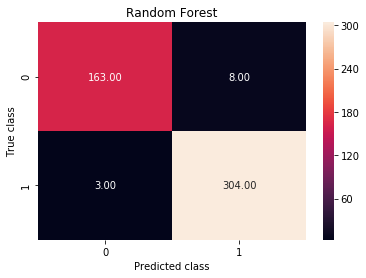

In [695]:
rf1 = RandomForestClassifier(n_estimators = 71,
                           max_depth = 6,
                           min_samples_leaf = 15)
rf1.fit(X_train, y_train)
scores_rf1 = cross_val_score(rf1, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rf1.mean(), 
                                                                      scores_rf1.std()*2))

y_pred = rf1.predict(X_train)
rf1_cm = metrics.confusion_matrix(y_pred, y_train, [1,0])
sns.heatmap(rf1_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('Random Forest')
print(classification_report(y_train, rf1.predict(X_train)))

In [696]:
rf1.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 71,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

My model performs... worse? with tuning. Again, we'll stick with the original model. We'll try SVC next. 

#### Support Vector Classifier

Cross Validation Accuracy Scores: 0.960(+/- 0.06)
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       312
          1       0.98      0.99      0.99       166

avg / total       0.99      0.99      0.99       478



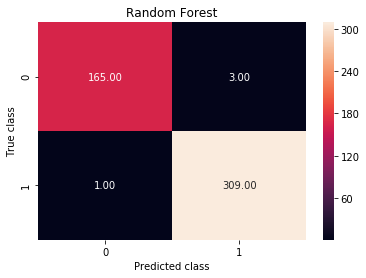

In [697]:


svc = SVC()
svc.fit(X_train,y_train)
scores_svc = cross_val_score(svc, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_svc.mean(), 
                                                                      scores_svc.std()*2))

y_pred = svc.predict(X_train)
svc_cm = metrics.confusion_matrix(y_pred, y_train, [1,0])
sns.heatmap(svc_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('Random Forest')
print(classification_report(y_train, svc.predict(X_train)))

Again, SVC works very well out of the box. We only have one type 2 error. We'll see if we can have better luck with hyperparameter tuning.

In [698]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create gamma hyperparameter
gamma = np.arange(0.1, 1, 0.2)

#create kernel hyperparameter
kernel = [ 'linear', 'poly', 'rbf', 'sigmoid' ]

# Create hyperparameter options
hyperparameters = dict(C=C, kernel = kernel, gamma = gamma)

# Create randomized search 5-fold cross validation and 10 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(svc, hyperparameters, random_state=1, n_iter=100, cv=5,n_jobs =10, verbose=1)

# Fit randomized search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters 
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print(clf.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    2.2s


Best kernel: linear
Best C: 1.66808801881
Best gamma: 0.9
0.970711297071


[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    5.6s finished


Cross Validation Accuracy Scores: 0.971(+/- 0.04)
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       312
          1       0.96      0.95      0.95       166

avg / total       0.97      0.97      0.97       478



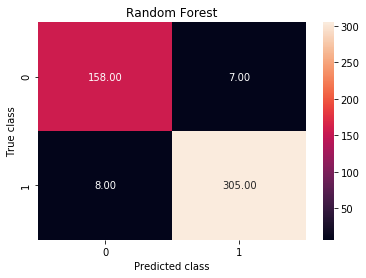

In [699]:

svc1 = SVC(kernel = 'linear',
          C = 1.66808801881,
          gamma = 0.9)
svc1.fit(X_train,y_train)
scores_svc1 = cross_val_score(svc1, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_svc1.mean(), 
                                                                      scores_svc1.std()*2))

y_pred = svc1.predict(X_train)
svc1_cm = metrics.confusion_matrix(y_pred, y_train, [1,0])
sns.heatmap(svc1_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('Random Forest')
print(classification_report(y_train, svc1.predict(X_train)))

And again, all of my models got worse in respects to precision, recall, and f1. We'll use all of the vanilla models on the test data below.

### Precision and Recall

#### Logistic Regression

Cross Validation Accuracy Scores: 0.966(+/- 0.08)
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       132
          1       0.97      0.95      0.96        73

avg / total       0.97      0.97      0.97       205



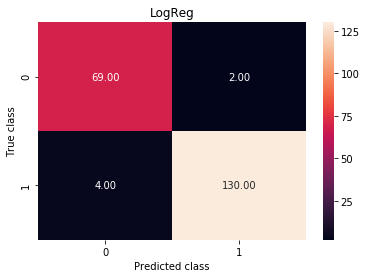

In [700]:
scores_lr = cross_val_score(lr, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr.mean(), 
                                                                      scores_lr.std()*2))

y_pred = lr.predict(X_test)
lr_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
sns.heatmap(lr_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('LogReg')
plt.savefig('LogReg')
print(classification_report(y_test, lr.predict(X_test)))

The logistic regression model does okay on the test data. Precision, recall, and f1 all go from .96 to .97. We still have twice as many type 2 erros as type one errors which is not ideal.

#### Random Forest

Cross Validation Accuracy Scores: 0.957(+/- 0.10)
             precision    recall  f1-score   support

          0       0.98      0.97      0.98       132
          1       0.95      0.97      0.96        73

avg / total       0.97      0.97      0.97       205



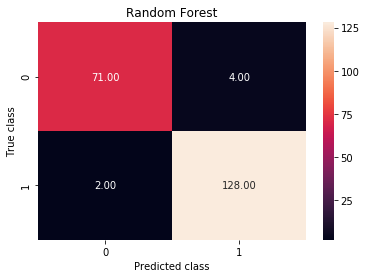

In [701]:
scores_rf = cross_val_score(rf, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rf.mean(), 
                                                                      scores_rf.std()*2))

y_pred = rf.predict(X_test)
rf_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
sns.heatmap(rf_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('Random Forest')
print(classification_report(y_test, rf.predict(X_test)))

RFC performs fairly well on the test data as well. The Accuracy is slightly worse with a higher standard deviation, but the recall is better for our malignant outcomes. 

#### Support Vector Classification

Cross Validation Accuracy Scores: 0.961(+/- 0.07)
             precision    recall  f1-score   support

          0       0.99      0.98      0.98       132
          1       0.96      0.99      0.97        73

avg / total       0.98      0.98      0.98       205



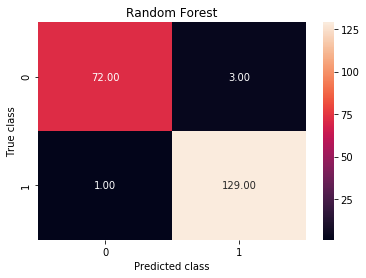

In [797]:
scores_svc = cross_val_score(svc, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_svc.mean(), 
                                                                      scores_svc.std()*2))

y_pred = svc.predict(X_test)
svc_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
sns.heatmap(svc_cm, annot=True, fmt='.2f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('Random Forest')
print(classification_report(y_test, svc.predict(X_test)))

SVC is the clear winner. We have a tighter range on cross-validation folds and we only have one type 1 error. 

SVC doesn't make it easy to determine feature importance, so we'll look at feature importances of the RFC and Liner regression models.

In [702]:
feature_labels = np.array(['clump_thickness','bare_nuclei','bland_chromatin','normal_nucleoli',
                                    'mitoses','cell_size_shape'])
importance = rf.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

mitoses-0.73%
clump_thickness-7.72%
bland_chromatin-10.68%
bare_nuclei-12.50%
normal_nucleoli-12.73%
cell_size_shape-55.63%


In [796]:
coef = lr.coef_.tolist()[0]
col = X_train.columns.tolist()
a = zip(col, coef)
print (tabulate(a, headers=['Feature','Coef'], floatfmt=(".4f",".4f")))

Feature            Coef
---------------  ------
clump_thickness  0.2052
bare_nuclei      0.3722
bland_chromatin  0.1186
normal_nucleoli  0.2894
mitoses          0.1831
cell_size_shape  0.3472


RFC had cell_size_shape as by far it's most important feature, but the linear regression model bare_nuclei has the largest coefficient and cell_size_shapeis a close second. This might explain why the Random Forest Classifier performed slightly better, at least in term of type 2 errors.

## Conclusion

SVC was the best model for this exercise: Classify whether a cell is cancerous or not. Our biggest concern is a large number of type 2 errors (False Negatives) that could be disastrous. The SVC model had an f-1 of .97 for the malignant class and still perfomed better than the Random Forest model for type 1 errors.